In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set paths in order to import packages correctly.
import sys
import os
sys.path.append(os.path.abspath("./..")) 
sys.path.append("./../quantum_machine_learning")

# `SSSKMParallelDenseLayer`

In [3]:
# Import the necessary packages.
import matplotlib.pyplot as plt
import numpy as np
import qiskit
from qiskit.primitives import BackendEstimatorV2
import qiskit_aer
from qiskit_aer.primitives import EstimatorV2
import torch
from tqdm.auto import tqdm

from quantum_machine_learning.dataset_gallery.dataset_gallery import DatasetGallery
from quantum_machine_learning.layers.blocks.ssskm_parallel_dense_layer import SSSKMParallelDenseLayer
from quantum_machine_learning.utils.utils import Utils

In [4]:
Utils.fix_seed(901)

Define a Torch customer layer by `SSSKMParallelDenseLayer` to incoporate with `torch.nn.Module`.

In [5]:
class QuantumParallelDense(torch.nn.Module):
    def __init__(self,
                 num_qubits: int,
                 num_reputations: int,
                 num_layers: int,
                 backend: qiskit.providers.BackendV2 = qiskit_aer.AerSimulator(),
                 estimator_class: BackendEstimatorV2 = EstimatorV2,
                 shots: int = 8192,
                 seed: int = 901,
                 optimisation_level: int = 3,
                 trainable_parameter_values: list[list[float]] | None = None
                ) -> None:
        super().__init__()
        self.num_qubits = num_qubits
        self.num_reputations = num_reputations
        self.num_layers = num_layers
        self.backend = backend
        self.estimator_class = estimator_class
        self.shots = shots
        self.seed = seed
        self.optimisation_level = optimisation_level

        if trainable_parameter_values is None:
            trainable_parameter_values = torch.rand(self.num_layers, 3 * self.num_qubits * self.num_reputations).tolist()
        self.parallel_dense = SSSKMParallelDenseLayer(
            num_qubits=self.num_qubits,
            num_reputations=self.num_reputations,
            num_layers=self.num_layers,
            trainable_parameter_values=trainable_parameter_values
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_list = []
        for _x in x.tolist():
            x_list.append(
                self.parallel_dense.run(
                    data=_x, backend=self.backend, estimator_class=self.estimator_class,
                    shots=self.shots, seed=self.seed, optimisation_level=self.optimisation_level,
                )
            )
        return torch.Tensor(x_list)

    def extra_repr(self) -> str:
        return f"num_qubits={self.num_qubits}, num_reputations={self.num_reputations}, num_layers={self.num_layers}"

Define `HQNNParallel` class, which inherits `torch.nn.Module` as same as the proposal in the original paper.

In [6]:
class HQNNParallel(torch.nn.Module):
    """
    HQNNParallel class for Mnist, of which input shape is (28, 28) and the number of classes is 10.
    """
    def __init__(self,
                 num_qubits: int,
                 num_reputations: int,
                 num_layers: int,
                 num_classes: int,
                 backend: qiskit.providers.BackendV2 = qiskit_aer.AerSimulator(),
                 estimator_class: BackendEstimatorV2 = EstimatorV2,
                 shots: int = 8192,
                 seed: int = 901,
                 optimisation_level: int = 3,
                 trainable_parameter_values: list[list[float]] | None = None
                ):
        torch.manual_seed(seed)
        super(HQNNParallel, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=1, dilation=1)  # 16x28x28
        self.max_pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1)  # 16x14x14
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, padding=2, stride=1, dilation=1)  # 32x14x14
        self.max_pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1)  # 32x7x7
        
        self.flatten = torch.nn.Flatten()  # 1568 = 32*7*7

        self.fc = torch.nn.Linear(1568, num_qubits * num_layers)

        self.quantum_paralell_dense = QuantumParallelDense(
            num_qubits=num_qubits,
            num_reputations=num_reputations,
            num_layers=num_layers,
            backend=backend,
            estimator_class=estimator_class,
            shots=shots,
            seed=seed,
            optimisation_level=optimisation_level,
            trainable_parameter_values=trainable_parameter_values
        )

        self.output = torch.nn.Linear(num_qubits * num_layers, num_classes)

        self.relu = torch.nn.functional.relu
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.quantum_paralell_dense(x)
        probabilities = self.softmax(self.output(x))
        return probabilities

    def classify(self, x: torch.Tensor) -> torch.Tensor:
        probabilities = self.forward(x)
        return torch.argmax(probabilities, dim=1)

In [7]:
torch.manual_seed(901)

num_qubits = 5
num_reputations = 3
num_layers = 4

hqnn_parallel = HQNNParallel(
    num_qubits=num_qubits,
    num_reputations=num_reputations,
    num_layers=num_layers,
    num_classes=2
)
hqnn_parallel

HQNNParallel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1568, out_features=20, bias=True)
  (quantum_paralell_dense): QuantumParallelDense(num_qubits=5, num_reputations=3, num_layers=4)
  (output): Linear(in_features=20, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [8]:
# Check if it works well.
data = torch.rand(3, 1, 28, 28)
hqnn_parallel(data)

tensor([[0.5027, 0.4973],
        [0.5077, 0.4923],
        [0.5028, 0.4972]], grad_fn=<SoftmaxBackward0>)

In [9]:
class TorchTrainer:
    """Trainer class."""

    def __init__(
        self,
        model: torch.nn.Module,
        quantum_lr: float,
        classical_lr: float,
    ):
        self.model = model
        self.quantum_lr = quantum_lr
        self.classical_lr = classical_lr
        self.current_epoch = 0
        self.freeze_quantum = False
        self.freeze_classical = False

        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimiser = torch.optim.Adam(self.model.named_parameters())

        self.train_loss_history = []
        self.test_loss_history = []

        self.train_accuracy_history = []
        self.test_accuracy_history = []

        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        else:
            self.device = torch.device("cpu")

    def __update(self, data: torch.Tensor, label: torch.Tensor) -> float:
        # Initialise the gradients.
        self.optimiser.zero_grad()
        # Calculate the loss for the classical part.
        loss = self.__calculate_loss(data=data, label=label)
        if not self.freeze_quantum:
            # Calculate the update term for the quantum part.
            quantum_update_term = self.__calculate_quanatum_update_term(data=data, label=label)
        
        if not self.freeze_classical:
            # Perform the backpropagation for the classical part.
            loss.backward()

            # Update the classical parameters.
            self.optimiser.step()
        
        if not self.freeze_quantum:
            # Update the quantum parameters.
            self.model.quantum_paralell_dense.parallel_dense._trainable_parameter_values = (
                np.array(self.model.quantum_paralell_dense.parallel_dense._trainable_parameter_values) - (self.quantum_lr * np.array(quantum_update_term))
            ).tolist()

        return loss.item()

    def __calculate_loss(
        self, data: torch.Tensor, label: torch.Tensor
    ) -> torch.nn.modules.loss._Loss:
        # Classify the data.
        output = self.model(data)
        # Calculate the loss value and accumulate it.
        loss = self.criterion(output, label)

        return loss

    def __calculate_quanatum_update_term(
        self, data: torch.Tensor, label: torch.Tensor
    ) -> list[list[float]]:
        update_terms = []
        with tqdm(range(self.model.quantum_paralell_dense.num_layers), leave=False) as tlayers:
            tlayers.set_description(f"Completed Calculation for Quantum Update Term per Layer")

            for layer_index in tlayers:
                # Get the corresponding layer, parameters and parameter values.
                trainable_parameter_values = self.model.quantum_paralell_dense.parallel_dense._trainable_parameter_values[layer_index]
    
                update_terms_for_one_layer = []
                for parameter_index in range(len(trainable_parameter_values)):
                    trainable_parameter_values_np = np.array(trainable_parameter_values)
                    
                    # Calculate forward shifted loss.
                    trainable_parameter_values_np[parameter_index] += np.pi / 2
                    self.model.quantum_paralell_dense.parallel_dense._trainable_parameter_values[layer_index] = (
                        trainable_parameter_values_np.tolist()
                    )
                    forward_loss = self.__calculate_loss(data=data, label=label)
    
                    # Calculate backward shifted loss.
                    trainable_parameter_values_np[parameter_index] -= np.pi
                    self.model.quantum_paralell_dense.parallel_dense._trainable_parameter_values[layer_index] = (
                        trainable_parameter_values_np.tolist()
                    )
                    backward_loss = self.__calculate_loss(data=data, label=label)
    
                    update_terms_for_one_layer.append(0.5 * (forward_loss.item() - backward_loss.item()))
                update_terms.append(update_terms_for_one_layer)
    
                self.model.quantum_paralell_dense.parallel_dense._trainable_parameter_values[layer_index] = trainable_parameter_values

        return update_terms
        
    def __train_one_epoch(self, train_loader: torch.utils.data.DataLoader):
        """Train the model."""
        self.model.train()

        train_loss = 0
        with tqdm(train_loader) as tepoch:
            # Initialise the count of correctly predicted data.
            total_correct = 0
            total = 0

            losses = []
            accuracies = []
            for data, label in tepoch:
                # Set the description.
                tepoch.set_description(f"Epoch {self.current_epoch} (train)")

                # Transfer the data and label to the device.
                data, label = data.to(self.device), label.to(self.device)

                # Update the parameters.
                loss_value = self.__update(data=data, label=label)
                train_loss += loss_value
                losses.append(loss_value)

                # Get the number of correctly predicted ones.
                predicted_label = self.model.classify(data)
                num_correct = (predicted_label == label).sum().item()
                total_correct += num_correct
                total += len(label)

                # Set the current loss and accuracy.
                batch_accuracy = num_correct / len(label)
                accuracies.append(batch_accuracy)
                epoch_loss = (np.array(losses).sum() / len(losses))
                epoch_accuracy = (np.array(accuracies).sum() / len(losses))
                tepoch.set_postfix(
                    {"Avg_loss_train": f"{epoch_loss :.2f}", "Avg_accuracy_train": f"{epoch_accuracy:.2f}"}
                )

        # Store the loss value.
        average_train_loss = train_loss / len(train_loader)
        self.train_loss_history.append(average_train_loss)

        # Store the accuracy.
        accuracy = total_correct / total
        self.train_accuracy_history.append(accuracy)

    def __eval_one_epoch(self, validation_loader: torch.utils.data.DataLoader):
        """Evaluate the model."""
        self.model.eval()

        test_loss = 0
        with tqdm(validation_loader) as tepoch:
            with torch.no_grad():  # without calculating the gradients.
                # Initialise the count of correctly predicted data.
                total_correct = 0
                total = 0

                losses = []
                accuracies = []
                for data, label in tepoch:
                    # Set the description.
                    tepoch.set_description(f"Epoch {self.current_epoch} (test)")

                    # Transfer the data and label to the device.
                    data, label = data.to(self.device), label.to(self.device)
                    # Calculate the loss.
                    loss_value = self.__calculate_loss(data=data, label=label).item()
                    test_loss += loss_value
                    losses.append(loss_value)

                    # Get the number of correctly predicted ones.
                    predicted_label = self.model.classify(data)
                    num_correct = (predicted_label == label).sum().item()
                    total_correct += num_correct
                    total += len(label)

                    # Set the current loss and accuracy.
                    batch_accuracy = num_correct / len(label)
                    accuracies.append(batch_accuracy)
                    
                    epoch_loss = (np.array(losses).sum() / len(losses))
                    epoch_accuracy = (np.array(accuracies).sum() / len(losses))
                    tepoch.set_postfix(
                        {"Avg_loss_train": f"{epoch_loss :.2f}", "Avg_accuracy_train": f"{epoch_accuracy:.2f}"}
                    )
        # Store the loss value.
        average_test_loss = test_loss / len(validation_loader)
        self.test_loss_history.append(average_test_loss)

        # Store the accuracy.
        accuracy = total_correct / total
        self.test_accuracy_history.append(accuracy)

    def train_and_eval(
        self,
        train_loader: torch.utils.data.DataLoader,
        validation_loader: torch.utils.data.DataLoader,
        epochs: int,
    ):
        """Train and evaluate the model self.epochs times."""
        for current_epoch in range(1, epochs + 1):
            self.current_epoch = current_epoch
            self.__train_one_epoch(train_loader=train_loader)
            # self.__eval_one_epoch(validation_loader=validation_loader)

In [10]:
class PlainDataset(torch.utils.data.Dataset):
    """PlainDataset class"""

    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        """Initialise this dataset.

        :param torch.Tensor x: data
        :param torch.Tensor y: labels
        """
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [11]:
images, labels = DatasetGallery.get_hor_ver_images(
    num_images=100,
    image_shape=(28, 28),
    line_length=14,
    line_pixel_value=np.pi / 2,
    min_noise_value=0,
    max_noise_value=np.pi / 4,
)
labels_np = np.array(labels)
labels_np[np.where(labels_np == "horizontal")] = 0
labels_np[np.where(labels_np == "vertical")] = 1
labels = torch.from_numpy(labels_np.astype(np.int64))

images = torch.from_numpy(images.astype(np.float32)).reshape(-1, 1, 28, 28)
print((labels==0).sum())
print((labels==1).sum())

tensor(42)
tensor(58)


In [12]:
hqnn_parallel(images[:5])

tensor([[0.5017, 0.4983],
        [0.5053, 0.4947],
        [0.5005, 0.4995],
        [0.5048, 0.4952],
        [0.5079, 0.4921]], grad_fn=<SoftmaxBackward0>)

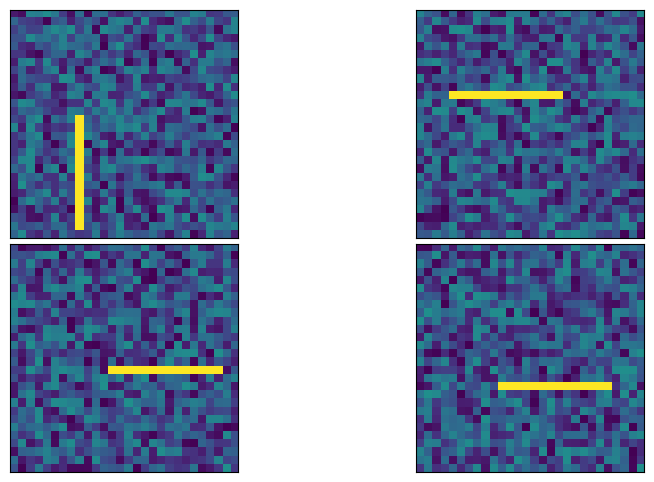

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
max_data = 4 if len(images) >= 4 else len(images)
for i in range(max_data):
    ax[i // 2, i % 2].imshow(
        images[i].reshape(28, 28),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

In [14]:
hor_ver_dataset = PlainDataset(images, labels)
dataloader = torch.utils.data.DataLoader(hor_ver_dataset, batch_size=1, shuffle=True)
len(dataloader)

100

In [15]:
(hqnn_parallel.classify(images) == labels).sum() / len(images)

tensor(0.4000)

In [16]:
torch_trainer = TorchTrainer(model=hqnn_parallel, quantum_lr=0.1, classical_lr=0.1)

epochs = 1
print((17 * 4 * len(images) * epochs) / 3600)  # Estimated time (hour)

torch_trainer.train_and_eval(dataloader, dataloader, epochs=epochs)

1.8888888888888888


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
(hqnn_parallel.classify(images) == labels).sum() / len(images)

tensor(0.5800)

In [18]:
torch_trainer.train_loss_history

[0.6929089558124543]

In [19]:
class CNNWithoutDense(torch.nn.Module):
    """
    CNN without a dense layer class for Mnist, of which input shape is (28, 28) and the number of classes is 10.
    """
    def __init__(self, num_classes: int, seed: int = 901):
        torch.manual_seed(seed)
        super(CNNWithoutDense, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=1, dilation=1)  # 16x28x28
        self.max_pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1)  # 16x14x14
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, padding=2, stride=1, dilation=1)  # 32x14x14
        self.max_pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1)  # 32x7x7
        
        self.flatten = torch.nn.Flatten()  # 1568 = 32*7*7

        self.output = torch.nn.Linear(1568, num_classes)

        self.relu = torch.nn.functional.relu
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.flatten(x)
        probabilities = self.softmax(self.output(x))
        return probabilities

    def classify(self, x: torch.Tensor) -> torch.Tensor:
        probabilities = self.forward(x)
        return torch.argmax(probabilities, dim=1)

In [20]:
cnn_without_dense = CNNWithoutDense(num_classes=2)
cnn_without_dense

CNNWithoutDense(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output): Linear(in_features=1568, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [21]:
(cnn_without_dense.classify(images) == labels).sum() / len(images)

tensor(0.5100)

In [22]:
torch_trainer_for_cnn_without_dense = TorchTrainer(model=cnn_without_dense, quantum_lr=0.1, classical_lr=0.1)
torch_trainer_for_cnn_without_dense.freeze_quantum = True

torch_trainer_for_cnn_without_dense.train_and_eval(dataloader, dataloader, epochs=epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
(cnn_without_dense.classify(images) == labels).sum() / len(images)

tensor(0.5800)

In [24]:
torch_trainer_for_cnn_without_dense.train_loss_history

[0.705688762664795]

In [25]:
class CNN(torch.nn.Module):
    """
    CNN class for Mnist, of which input shape is (28, 28) and the number of classes is 10.
    """
    def __init__(self, num_classes: int, num_dense_output: int, seed: int = 901):
        torch.manual_seed(seed)
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=1, dilation=1)  # 16x28x28
        self.max_pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1)  # 16x14x14
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, padding=2, stride=1, dilation=1)  # 32x14x14
        self.max_pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1)  # 32x7x7
        
        self.flatten = torch.nn.Flatten()  # 1568 = 32*7*7

        self.fc = torch.nn.Linear(1568, num_dense_output)
        
        self.output = torch.nn.Linear(num_dense_output, num_classes)

        self.relu = torch.nn.functional.relu
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.flatten(x)
        x = self.fc(x)
        probabilities = self.softmax(self.output(x))
        return probabilities

    def classify(self, x: torch.Tensor) -> torch.Tensor:
        probabilities = self.forward(x)
        return torch.argmax(probabilities, dim=1)

In [26]:
cnn = CNN(num_classes=2, num_dense_output=num_qubits*num_layers)
cnn

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1568, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [27]:
(cnn.classify(images) == labels).sum() / len(images)

tensor(0.5800)

In [28]:
torch_trainer_for_cnn = TorchTrainer(model=cnn, quantum_lr=0.1, classical_lr=0.1)
torch_trainer_for_cnn.freeze_quantum = True

torch_trainer_for_cnn.train_and_eval(dataloader, dataloader, epochs=epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
(cnn.classify(images) == labels).sum() / len(images)

tensor(0.5800)

In [30]:
torch_trainer_for_cnn.train_loss_history

[0.7046664923429489]